# Forecasting Inflation Rate Using ARIMA Model in Python

# Loading and Processing Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# ignore harmless warnings
import warnings
warnings.filterwarnings('ignore')

In [28]:
# import data from xlsx file
dataset = pd.read_excel('inflation_rate.xlsx')
dataset.tail()

,Year,1,2,3,4,5,6,7,8,9,10,11,12
20,2017,1.4,1.9,1.8,1.8,1.5,1.3,1.4,1.4,1.6,1.6,2.0,1.7
21,2018,1.6,0.7,0.7,0.9,1.2,1.4,1.4,1.4,1.5,1.5,1.1,0.9
22,2019,0.6,1.3,1.7,2.1,2.2,2.3,2.5,2.6,2.4,2.3,2.4,3.0
23,2020,3.8,4.1,3.9,2.9,3.4,3.8,3.7,3.7,3.8,3.8,3.7,3.4
24,2021,3.6,3.6,4.4,5.1,4.6,4.1,4.7,5.0,5.6,6.4,7.7,NaN


In [4]:
# unpivot from wide to long format
dataset = dataset.melt(id_vars=['Year'], var_name='Month', value_name='Rate')
dataset.head()

,Year,Month,Rate
0,1997,1,17.7
1,1998,1,13.6
2,1999,1,6.8
3,2000,1,10.1
4,2001,1,7.4


In [5]:
# add new date column and assign last day of month
from pandas.tseries.offsets import MonthEnd
dataset['Date'] = pd.to_datetime(dataset[['Year', 'Month']].assign(DAY=1)) + MonthEnd(1)

# order ascending data values 
dataset = dataset.sort_values(by=['Date'])
dataset.head()

,Year,Month,Rate,Date
0,1997,1,17.7,1997-01-31
25,1997,2,17.4,1997-02-28
50,1997,3,16.5,1997-03-31
75,1997,4,15.3,1997-04-30
100,1997,5,14.4,1997-05-31


In [6]:
# select needed columns
df = dataset[['Date', 'Rate']]

# set date column as index
df.set_index('Date', inplace=True)

# drop NaN rows
df.dropna(subset=['Rate'], inplace=True)
df.tail()

,Rate
Date,
2021-07-31,4.7
2021-08-31,5.0
2021-09-30,5.6
2021-10-31,6.4
2021-11-30,7.7


In [7]:
# summary of final DataFrame
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Rate,299.0,3.751171,3.81678,-1.3,1.2,3.0,4.4,17.7


# Visualizing Time Series

<Axes: xlabel='Date'>

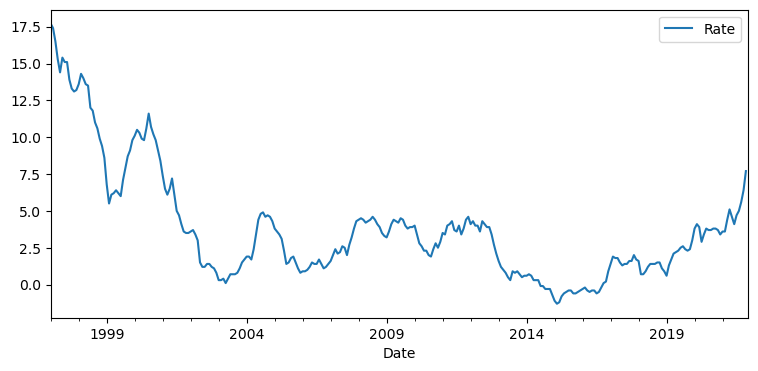

In [10]:
#time series of inflation percentage
dataset.plot(x='Date', y='Rate', figsize=(9,4))

#  Identifying if the Data is Stationary

In [12]:
# check if inflation series is stationary
from statsmodels.tsa.stattools import adfuller

# ADF test
def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print('1. ADF: ', result[0])
    print('2. P-value: ', result[1])
    print('3. Num of Lags: ', result[2])
    print('4. Num of Observations: ', result[3])
    print('5. Critial Values:')
    for key, value in result[4].items():
        print('\t', key, ': ', value)
        
    if result[1] <= 0.05:
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

# run function
adf_test(df['Rate'])

1. ADF:  -3.841632389326832
2. P-value:  0.002508958180327525
3. Num of Lags:  13
4. Num of Observations:  285
5. Critial Values:
	 1% :  -3.4535050041524245
	 5% :  -2.8717352599720294
	 10% :  -2.5722024776854417

Strong evidence against the null hypothesis (H0), reject the null hypothesis. Data has no unit root and is stationary.


# Differencing - Determining d Order

In [13]:
# finding differencing value
from pmdarima.arima.utils import ndiffs
print(ndiffs(df['Rate'], test='adf'))
print(ndiffs(df['Rate'], test='kpss'))
print(ndiffs(df['Rate'], test='pp'))

1
2
1


# Autocorrelation (ACF) and Partial Autocorrelation (PACF) - Determining p and q Order

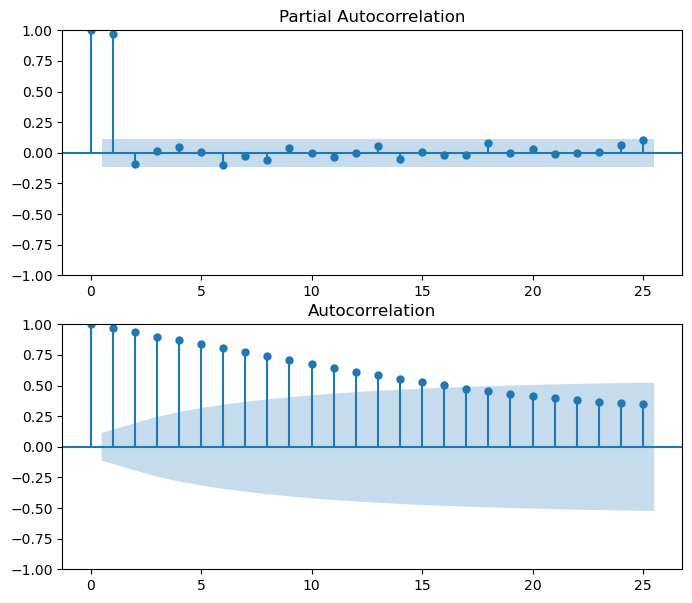

In [14]:
# plotting ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(8,7))
ax1 = fig.add_subplot(2,1,1)
fig = plot_pacf(df, ax=ax1)
ax2 = fig.add_subplot(2,1,2)
fig = plot_acf(df, ax=ax2)
plt.show()

# Auto ARIMA Function to Find Best Order for Model

In [15]:
# auto ARIMA function
from pmdarima import auto_arima
stepwise_fit = auto_arima(df['Rate'], trace=True, suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=332.745, Time=0.31 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=420.078, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=399.241, Time=0.06 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=361.354, Time=0.07 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=330.280, Time=0.18 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=333.189, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=328.746, Time=0.16 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=330.214, Time=0.22 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=384.237, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.43 sec

Best model:  ARIMA(1,2,1)(0,0,0)[0]          
Total fit time: 1.681 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  299
Model:               SARIMAX(1, 2, 1)   Log Likelihood                -161.373
Date:                Fri, 24 Nov 2023   AIC                            328.746
Time:                        00:19:19   BIC                            339.827
Sample:                    01-31-1997   HQIC                           333.182
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4007      0.049      8.171      0.000       0.305       0.497
ma.L1         -0.9786      0.020    -47.909      0.000      -1.019      -0.939
sigma2         0.1722      0.011     16.284      0.000       0.151       0.193
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                44.21
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Developing the ARIMA Model

In [16]:
# p=2, d=0, q=1
from statsmodels.tsa.arima.model import ARIMA

# fitting the model
model = ARIMA(df['Rate'], order=(2,0,1), freq='M')
model_fit = model.fit()
model_fit.summary()

C:\Users\Hritik\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                   Rate   No. Observations:                  299
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -163.645
Date:                Fri, 24 Nov 2023   AIC                            337.290
Time:                        00:19:22   BIC                            355.792
Sample:                    01-31-1997   HQIC                           344.695
                         - 11-30-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5754      3.770      2.275      0.023       1.187      15.964
ar.L1          1.3885      0.102     13.585      0.000       1.188       1.589
ar.L2         -0.3924      0.101     -3.868      0.000      -0.591      -0.194
ma.L1          0.0475      0.126      0.379      0.705      -0.198       0.294
sigma2         0.1717      0.010     16.368      0.000       0.151       0.192
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                39.20
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [18]:
# predict values
pred = model_fit.predict(start=0, end=len(df) - 1, typ='levels', dynamic=False)

In [19]:
# display last rows
pred.tail()

2021-07-31    3.907970
2021-08-31    4.988289
2021-09-30    5.132289
2021-10-31    5.869340
2021-11-30    6.747679
Freq: M, Name: predicted_mean, dtype: float64

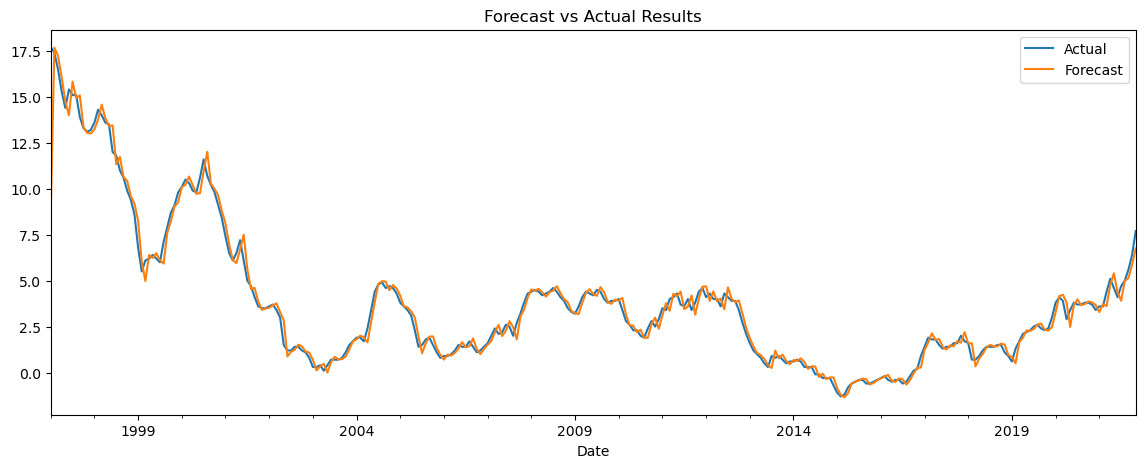

In [20]:
# plot results
df['Rate'].plot(legend=True, label='Actual', figsize=(14,5))
pred.plot(legend=True, label='Forecast')
plt.title('Forecast vs Actual Results')
plt.show()

# Extrapolating Future Inflation Data

In [25]:
# predict values
forecast = model_fit.predict(start=0, end=len(df) + 4, typ='levels', dynamic=False)

In [26]:
# display forecasted values
forecast.tail(5)

2021-12-31    8.258834
2022-01-31    8.479362
2022-02-28    8.566274
2022-03-31    8.600414
2022-04-30    8.613713
Freq: M, Name: predicted_mean, dtype: float64

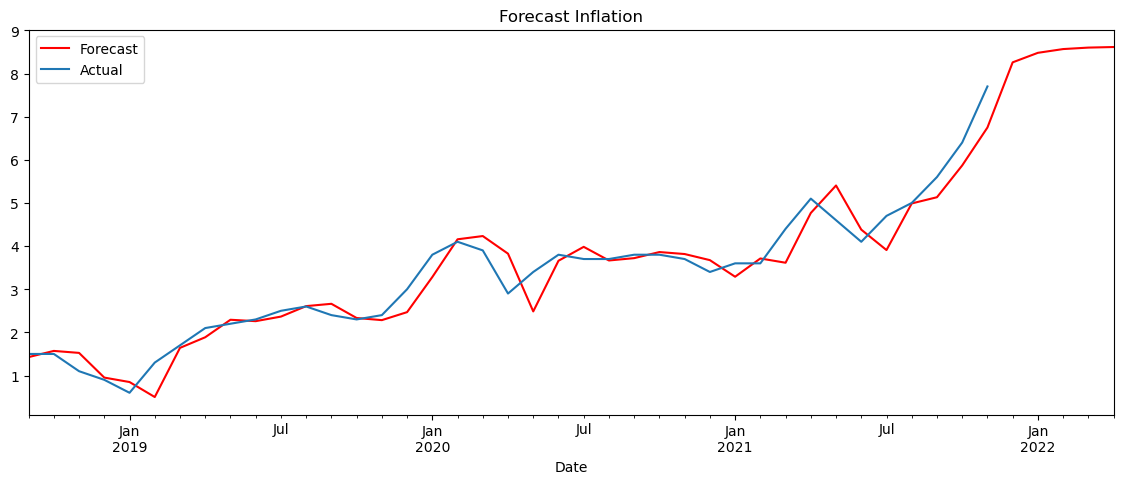

In [27]:
# final plot
forecast.iloc[260:].plot(legend=True, label='Forecast', figsize=(14,5), color='red')
df['Rate'].iloc[260:].plot(legend=True, label='Actual')
plt.title('Forecast Inflation')
plt.show()